In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import nrrd
import pandas as pd
import os
import sys

sys.path.append("/mnt/raid/C1_ML_Analysis/source/autoencoder/src")

from nets import diffusion
from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler

import monai
from monai.transforms import (    
    AsChannelFirst,
    AddChannel,
    Compose,    
    RandFlip,
    RandRotate,
    CenterSpatialCrop,
    ScaleIntensityRange,
    RandAdjustContrast,
    RandGaussianNoise,
    RandGaussianSmooth
)


/mnt/raid/home/jprieto/anaconda3/envs/torch_us/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/raid/home/jprieto/anaconda3/envs/torch_us/lib/python3.8/site-packages/neptune/internal/backends/hosted_client.py:50: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
/mnt/raid/home/jprieto/anaconda3/envs/torch_us/lib/python3.8/site-packages/pytorch_lightning/loggers/neptune.py:39: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  from neptune imp

In [2]:
mount_point = '/mnt/raid/C1_ML_Analysis'
df = pd.read_parquet(os.path.join(mount_point, "CSV_files", "extract_frames_blind_sweeps_c1_30082022_wscores_test_w16_kmeans_sample_train.parquet"))
df = df.query('score > 0.999').reset_index(drop=True)

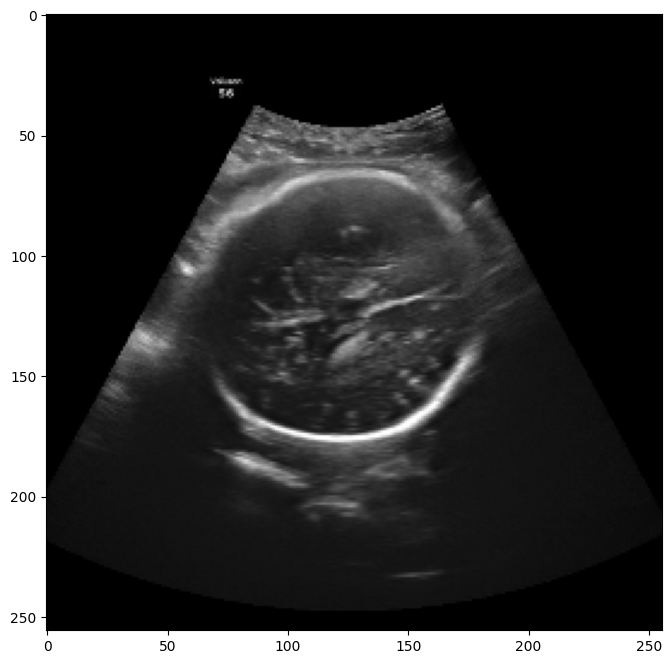

In [3]:
mpl.rcParams['figure.figsize'] = (12, 8)

img_np, head = nrrd.read(os.path.join(mount_point, df['img_path'][0]), index_order="C")

img = torch.FloatTensor(img_np/255)

def input_T(input):
    # [0,1] -> [-1,+1]
    return 2*input-1
    
def output_T(input):
    # [-1,+1] -> [0,1]
    return (input+1)/2

def show(input):
    plt.imshow(output_T(input).clip(0,1), cmap='gray')
    
img_=input_T(img)
show(img_)


In [4]:
#Defining the schedule for the diffusion process
num_timesteps=1000
betas=torch.linspace(1e-4,2e-2,num_timesteps)

alphas=1-betas
alphas_sqrt=alphas.sqrt()
alphas_cumprod=torch.cumprod(alphas,0)
alphas_cumprod_sqrt=alphas_cumprod.sqrt()

In [5]:
def forward_step(t, condition_img, return_noise=False):
    """
        forward step: t-1 -> t
    """    
    assert t >= 0

    mean=alphas_sqrt[t]*condition_img    
    std=betas[t].sqrt()
      
    # sampling from N
    if not return_noise:
        return mean+std*torch.randn_like(img)
    else:
        noise=torch.randn_like(img)
        return mean+std*noise, noise
    
def forward_jump(t, condition_img, condition_idx=0, return_noise=False):
    """
        forward jump: 0 -> t
    """   
    assert t >= 0
    
    mean=alphas_cumprod_sqrt[t]*condition_img
    std=(1-alphas_cumprod[t]).sqrt()
      
    # sampling from N
    if not return_noise:
        return mean+std*torch.randn_like(img)
    else:
        noise=torch.randn_like(img)
        return mean+std*noise, noise

In [6]:
N=5 # number of computed states between x_0 and x_T
M=4 # number of samples taken from each distribution

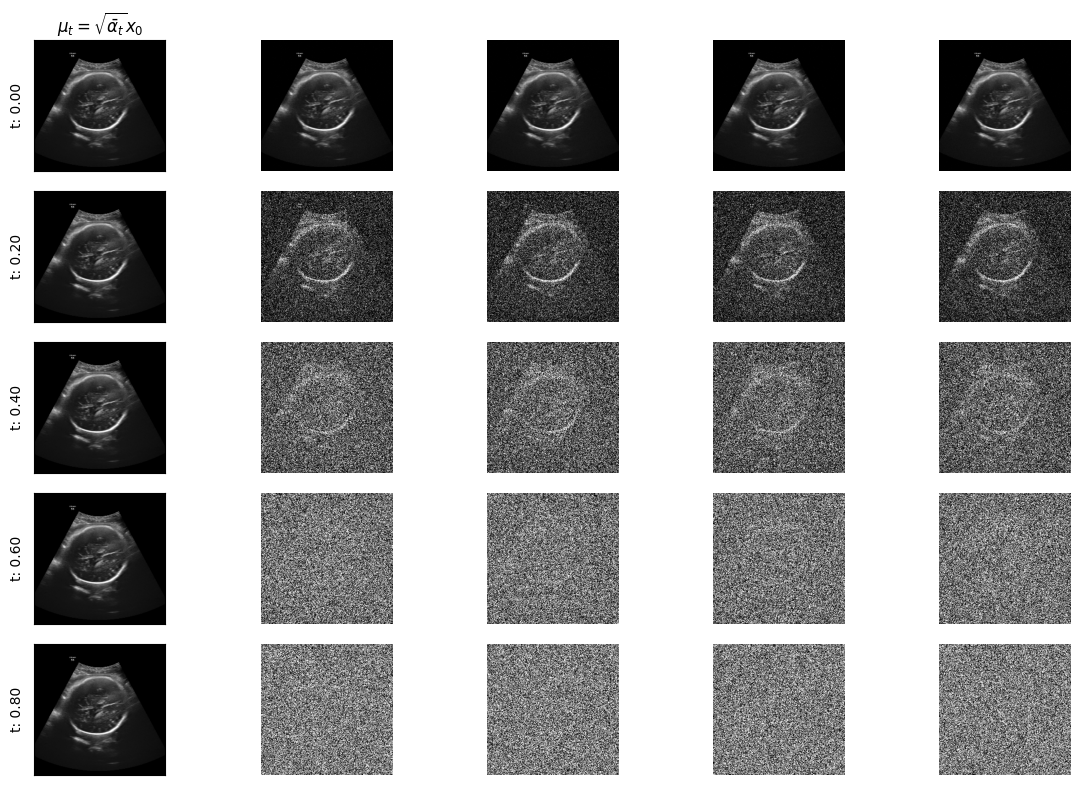

In [7]:
plt.figure(figsize=(12,8))
for idx in range(N):
    t_step=int(idx*(num_timesteps/N))
    
    plt.subplot(N,1+M,1+(M+1)*idx)
    show(alphas_cumprod_sqrt[t_step]*img_)
    plt.title(r'$\mu_t=\sqrt{\bar{\alpha}_t}x_0$') if idx==0 else None
    plt.ylabel("t: {:.2f}".format(t_step/num_timesteps))
    plt.xticks([])
    plt.yticks([])
    
    for sample in range(M):
        x_t=forward_jump(t_step,img_)
        
        plt.subplot(N,1+M,2+(1+M)*idx+sample)
        show(x_t)        
        plt.axis('off')
        
plt.tight_layout()

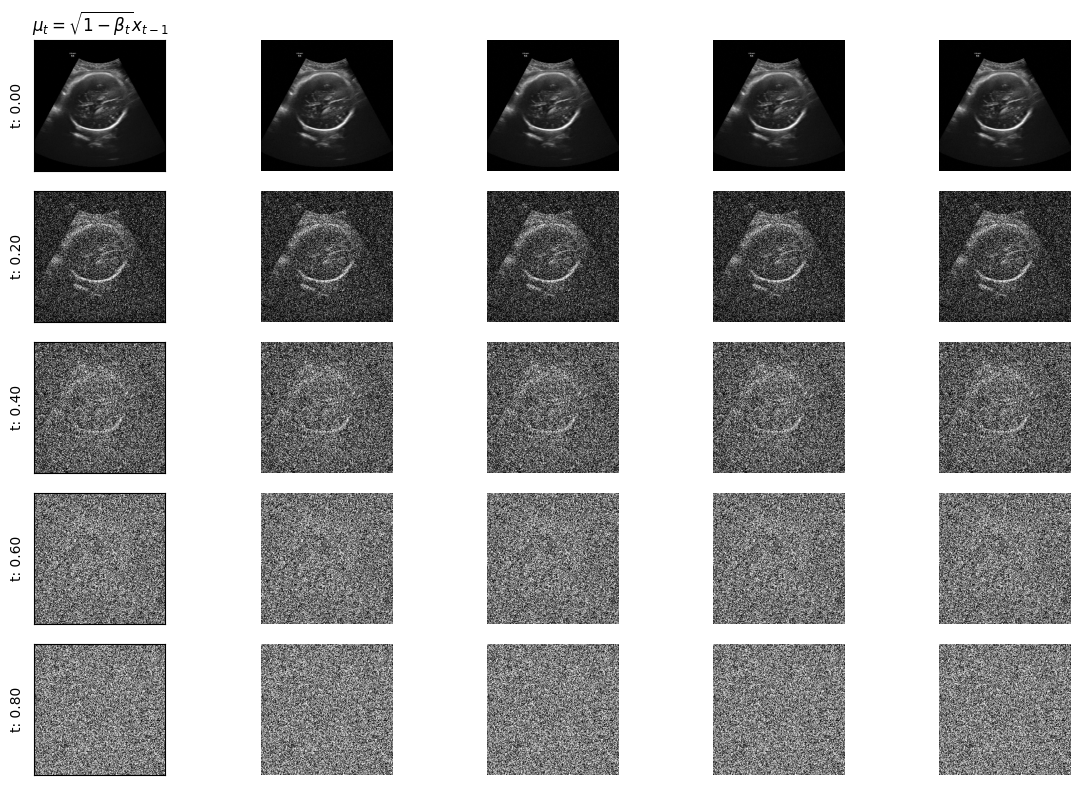

In [8]:
plt.figure(figsize=(12,8))
for idx in range(N):
    t_step=int(idx*(num_timesteps/N))
    prev_img=forward_jump(max([0,t_step-1]),img_) # directly go to prev state
    
    plt.subplot(N,1+M,1+(M+1)*idx)
    show(alphas_sqrt[t_step]*prev_img)
    plt.title(r'$\mu_t=\sqrt{1-\beta_t}x_{t-1}$') if idx==0 else None
    plt.ylabel("t: {:.2f}".format(t_step/num_timesteps))
    plt.xticks([])
    plt.yticks([])
    
    for sample in range(M):
        plt.subplot(N,1+M,2+(1+M)*idx+sample)
        x_t=forward_step(t_step,prev_img)
        show(x_t)        
        plt.axis('off')
plt.tight_layout()

(-0.5, 255.5, 255.5, -0.5)

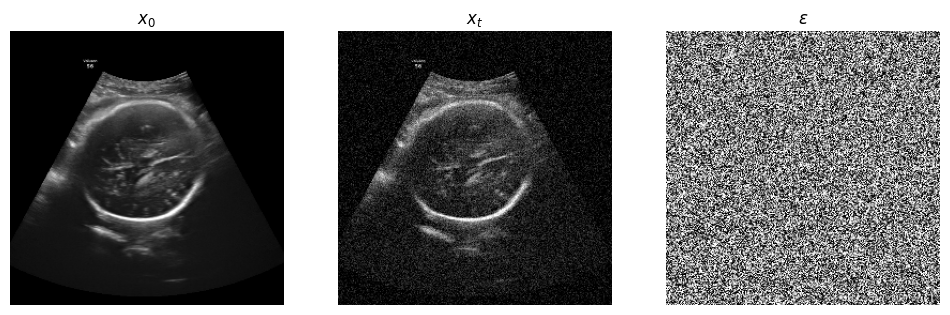

In [9]:
t_step=50

x_t,noise=forward_jump(t_step,img_,return_noise=True)

plt.subplot(1,3,1)
show(img_)
plt.title(r'$x_0$')
plt.axis('off')
plt.subplot(1,3,2)
show(x_t)
plt.title(r'$x_t$')
plt.axis('off')
plt.subplot(1,3,3)
show(noise)
plt.title(r'$\epsilon$')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

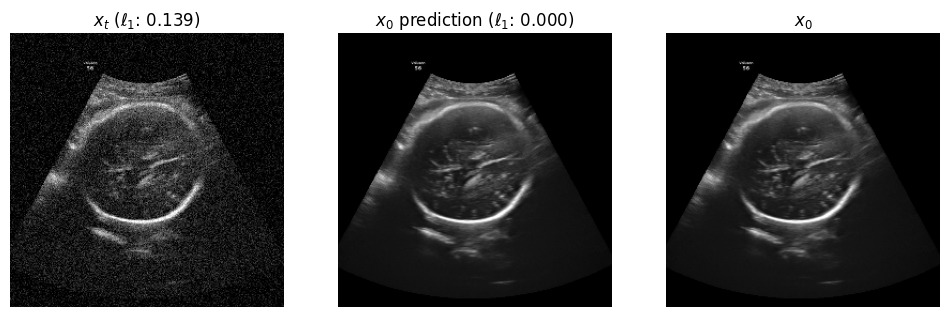

In [10]:
x_0_pred=(x_t-(1-alphas_cumprod[t_step]).sqrt()*noise)/(alphas_cumprod_sqrt[t_step])

plt.subplot(1,3,1)
show(x_t)
plt.title('$x_t$ ($\ell_1$: {:.3f})'.format(F.l1_loss(x_t,img_)))
plt.axis('off')
plt.subplot(1,3,2)
show(x_0_pred)
plt.title('$x_0$ prediction ($\ell_1$: {:.3f})'.format(F.l1_loss(x_0_pred,img_)))
plt.axis('off') 
plt.subplot(1,3,3)
show(img_)
plt.title('$x_0$')
plt.axis('off')

In [11]:
# estimate mean
mean_pred=x_0_pred*(alphas_cumprod_sqrt[t_step-1]*betas[t_step])/(1-alphas_cumprod[t_step]) + x_t*(alphas_sqrt[t_step]*(1-alphas_cumprod[t_step-1]))/(1-alphas_cumprod[t_step])

# let's compare it to ground truth mean of the previous step (requires knowledge of x_0)
mean_gt=alphas_cumprod_sqrt[t_step-1]*img_

Text(0.5, 1.0, '$\\mu_{t-1}$  ($\\ell_1$: 0.012)')

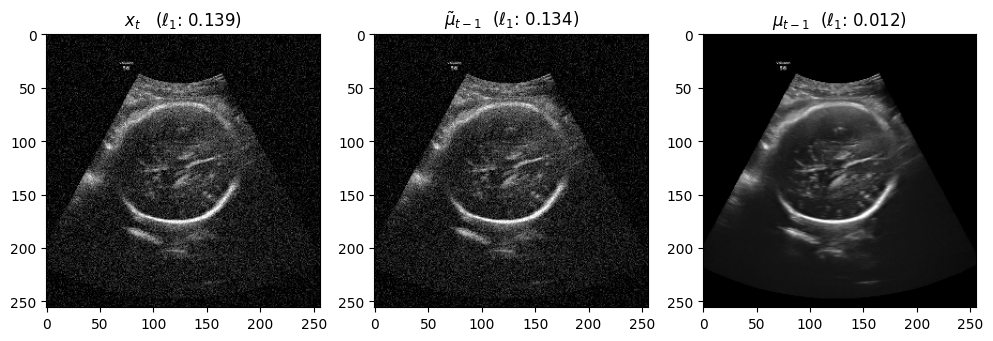

In [12]:
plt.subplot(1,3,1)
show(x_t)
plt.title('$x_t$   ($\ell_1$: {:.3f})'.format(F.l1_loss(x_t,img_)))
plt.subplot(1,3,2)
show(mean_pred)
plt.title(r'$\tilde{\mu}_{t-1}$' + '  ($\ell_1$: {:.3f})'.format(F.l1_loss(mean_pred,img_)))
plt.subplot(1,3,3)
show(mean_gt)
plt.title(r'$\mu_{t-1}$' + '  ($\ell_1$: {:.3f})'.format(F.l1_loss(mean_gt,img_)))

In [13]:
def reverse_step(epsilon, x_t, t_step, return_noise=False):
    
    # estimate x_0 based on epsilon
    x_0_pred=(x_t-(1-alphas_cumprod[t_step]).sqrt()*epsilon)/(alphas_cumprod_sqrt[t_step])
    if t_step==0:
        sample=x_0_pred
        noise=torch.zeros_like(x_0_pred)
    else:
        # estimate mean
        mean_pred=x_0_pred*(alphas_cumprod_sqrt[t_step-1]*betas[t_step])/(1-alphas_cumprod[t_step]) + x_t*(alphas_sqrt[t_step]*(1-alphas_cumprod[t_step-1]))/(1-alphas_cumprod[t_step])

        # compute variance
        beta_pred=betas[t_step].sqrt() if t_step != 0 else 0

        sample=mean_pred+beta_pred*torch.randn_like(x_t)
        # this noise is only computed for simulation purposes (since x_0_pred is not known normally)
        noise=(sample-x_0_pred*alphas_cumprod_sqrt[t_step-1])/(1-alphas_cumprod[t_step-1]).sqrt()
    if return_noise:
        return sample, noise
    else:
        return sample

In [14]:
model_fn = "/mnt/raid/C1_ML_Analysis/train_output/diffusion/extract_frames_blind_sweeps_c1_30082022_wscores_1e-4_ddpmpl_v1.0/epoch=67-val_loss=0.12.ckpt"

NN = getattr(diffusion, "DDPMPL")
model = NN.load_from_checkpoint(model_fn)
model.eval()
model.cuda()

DDPMPL(
  (model): DiffusionModelUNet(
    (conv_in): Convolution(
      (conv): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (time_embed): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock(
        (resnets): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (nonlinearity): SiLU()
            (conv1): Convolution(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv2): Convolution(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (skip_connection): I

In [15]:
scheduler = DDPMScheduler(num_train_timesteps=1000)
inferer = DiffusionInferer(scheduler=scheduler)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.84it/s]


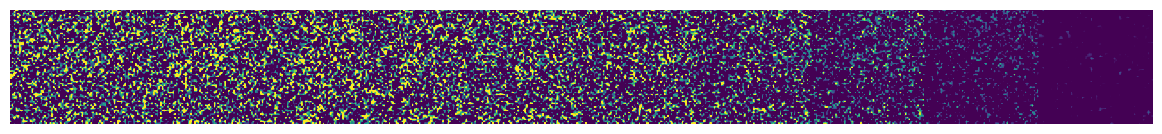

2023-06-20 12:21:20,159 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


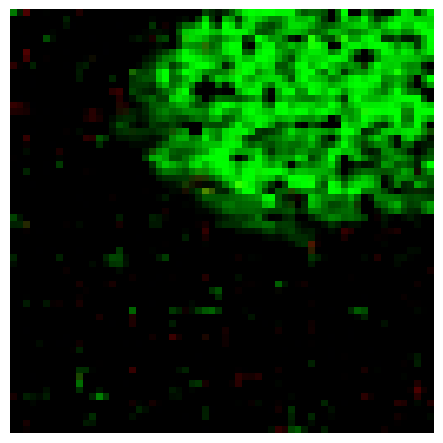

In [16]:
noise = torch.randn((1, 3, 64, 64))
noise = noise.cuda()
scheduler.set_timesteps(num_inference_steps=1000)


image, intermediates = inferer.sample(
    input_noise=noise, diffusion_model=model.model, scheduler=scheduler, save_intermediates=True, intermediate_steps=100
)

chain = torch.cat(intermediates, dim=-1)

plt.figure(figsize=(12,8))
plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1)
plt.tight_layout()
plt.axis("off")
plt.show()

plt.style.use("default")
plt.imshow(image[0].cpu().permute(1,2,0), vmin=0, vmax=1)
plt.tight_layout()
plt.axis("off")
plt.show()

In [17]:
model_fn = "/mnt/raid/C1_ML_Analysis/train_output/diffusion/extract_frames_blind_sweeps_c1_30082022_wscores_1e-4_ddpmpl_v3.0/epoch=77-val_loss=0.14.ckpt"

NN = getattr(diffusion, "DDPMPL")
model = NN.load_from_checkpoint(model_fn)
model.eval()
model.cuda()

DDPMPL(
  (model): DiffusionModelUNet(
    (conv_in): Convolution(
      (conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (time_embed): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock(
        (resnets): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (nonlinearity): SiLU()
            (conv1): Convolution(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv2): Convolution(
              (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (skip_connection): I

In [18]:
scheduler = DDPMScheduler(num_train_timesteps=1000)
inferer = DiffusionInferer(scheduler=scheduler)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 121.96it/s]


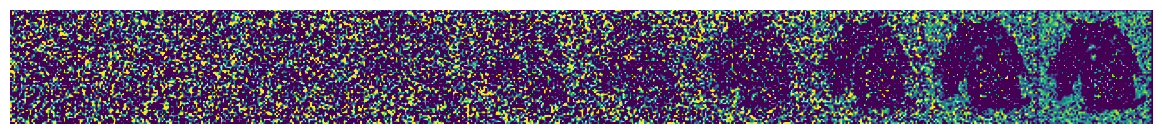

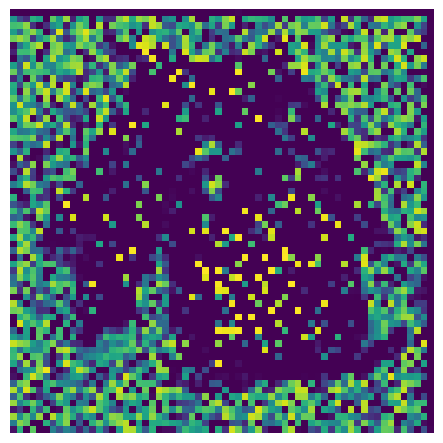

In [19]:
noise = torch.randn((1, 1, 64, 64))
noise = noise.cuda()
scheduler.set_timesteps(num_inference_steps=1000)


image, intermediates = inferer.sample(
    input_noise=noise, diffusion_model=model.model, scheduler=scheduler, save_intermediates=True, intermediate_steps=100
)

chain = torch.cat(intermediates, dim=-1)

plt.figure(figsize=(12,8))
plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1)
plt.tight_layout()
plt.axis("off")
plt.show()

plt.style.use("default")
plt.imshow(image[0].cpu().permute(1,2,0), vmin=0, vmax=1)
plt.tight_layout()
plt.axis("off")
plt.show()

In [20]:
model_autoencoder_fn = "/mnt/raid/C1_ML_Analysis/train_output/diffusion/extract_frames_blind_sweeps_c1_30082022_wscores_1e-4_v4.0/epoch=21-val_loss=29.28.ckpt"

NN = getattr(diffusion, "AutoEncoderTanhPL")
model_autoencoder = NN.load_from_checkpoint(model_autoencoder_fn)
model_autoencoder.eval()
model_autoencoder.cuda()

/mnt/raid/home/jprieto/anaconda3/envs/torch_us/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/mnt/raid/home/jprieto/anaconda3/envs/torch_us/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AutoEncoderTanhPL(
  (autoencoder): AutoEncoderTanh(
    (encoder): Encoder(
      (blocks): ModuleList(
        (0): Convolution(
          (conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): ResBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Convolution(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (nin_shortcut): Identity()
        )
        (2): ResBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Convolution(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv2): Convolution(
      

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:28<00:00, 11.26it/s]


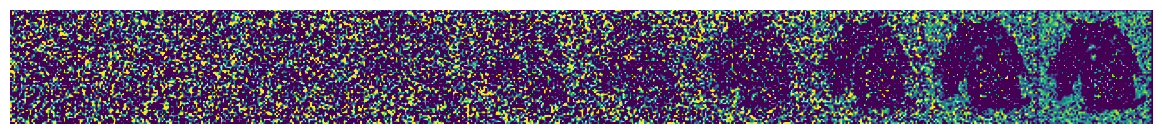

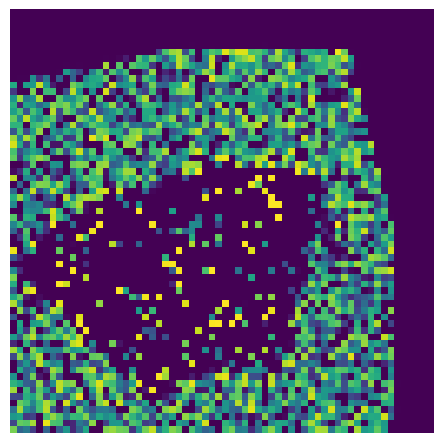

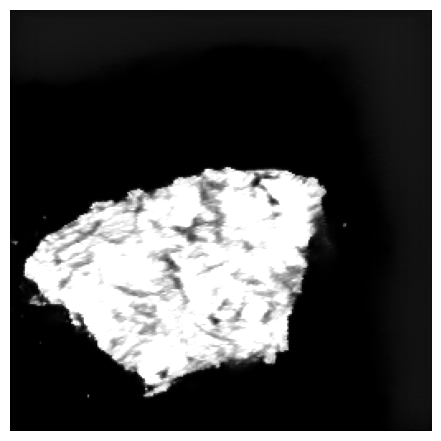

In [21]:
noise = torch.randn((96, 1, 64, 64))
noise = noise.cuda()
scheduler.set_timesteps(num_inference_steps=1000)


# image, intermediates = inferer.sample(
#     input_noise=noise, diffusion_model=model.model, scheduler=scheduler, save_intermediates=False, intermediate_steps=2
# )

image = inferer.sample(
    input_noise=noise, diffusion_model=model.model, scheduler=scheduler, save_intermediates=False
)

chain = torch.cat(intermediates, dim=-1)

plt.figure(figsize=(12,8))
plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1)
plt.tight_layout()
plt.axis("off")
plt.show()

plt.style.use("default")
plt.imshow(image[0].cpu().permute(1,2,0), vmin=0, vmax=1)
plt.tight_layout()
plt.axis("off")
plt.show()

reconstruction = model_autoencoder.autoencoder.decode(image)

plt.style.use("default")
plt.imshow(reconstruction[0].detach().cpu().permute(1,2,0), vmin=0, vmax=1, cmap='gray')
plt.tight_layout()
plt.axis("off")
plt.show()